In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from typing import Optional, Tuple, Union
from ot import emd2_1d
from dem.models.components.optimal_transport import wasserstein
from dem.utils.data_utils import remove_mean
from dem.utils.logging_utils import fig_to_image

In [2]:
import sys
sys.path.append('..')


In [3]:
from dem.energies.multi_double_well_energy import MultiDoubleWellEnergy

In [4]:
energy= MultiDoubleWellEnergy(
            dimensionality= 8,
            n_particles= 4,
            data_from_efm= True,
            data_path= "../data/test_split_DW4.npy",
            data_path_train= "../data/train_split_DW4.npy",
            data_path_val= "../data/val_split_DW4.npy",
            device='cpu',
            data_normalization_factor= 1.0,
            is_molecule= True)

In [5]:
def _calc_dist_total_var(
    gt_samples: torch.Tensor,
    latest_samples: torch.Tensor,
    system_shape: Union[torch.Size, Tuple[int]],
    energy_function    ) -> torch.Tensor:
    x = gt_samples.view(*system_shape)
    y = latest_samples.view(*system_shape) if latest_samples.device == "cpu" else latest_samples.detach().cpu().view(*system_shape)
    
    if x.size(-1) == 3:
        generated_samples_dists = (
            energy_function.interatomic_dist(x).cpu().numpy().reshape(-1),
        )
        data_set_dists = energy_function.interatomic_dist(y).cpu().numpy().reshape(-1)

        H_data_set, x_data_set = torch.histogram(data_set_dists, bins=200)
        H_generated_samples, _ = torch.histogram(generated_samples_dists, bins=(x_data_set))
        total_var = (
            0.5
            * torch.abs(
                H_data_set / H_data_set.sum() - H_generated_samples / H_generated_samples.sum()
            ).sum()
        )
    else:
        H_data_set_x, x_data_set = torch.histogram(x[:, 0], bins=200)
        H_data_set_y, _ = torch.histogram(x[:, 1], bins=(x_data_set))
        H_generated_samples_x, _ = torch.histogram(y[:, 0], bins=(x_data_set))
        H_generated_samples_y, _ = torch.histogram(y[:, 1], bins=(x_data_set))
        total_var = (
            0.5
            * (
                torch.abs(
                    H_data_set_x / H_data_set_x.sum() - H_generated_samples_x / H_generated_samples_x.sum()
                ) +
                torch.abs(
                    H_data_set_y / H_data_set_y.sum() - H_generated_samples_y / H_generated_samples_y.sum()
                )
            ).sum()
        )
    return total_var

def get_hist_metrics(samples,test,prefix="",range=(0,7)):
    metrics={}
    samples_hist,_=np.histogram(samples.view(-1),bins=100,density=True,range=range)
    test_hist,_=np.histogram(test.view(-1),bins=100,density=True,range=range)
    #w2 distance
    w2=emd2_1d(samples.view(-1),test.view(-1),metric="euclidean")
    #l2 distance
    l2_distance = np.linalg.norm(samples_hist - test_hist)
    metrics[prefix+"L2 Distance"]=l2_distance
    metrics[prefix+"W2 Distance"]=w2
    return metrics

def compute_metrics(energy,initial_samples,test_set,plot_figs=True):
    log_metrics={}
    current_samples_idx=torch.multinomial(torch.ones(initial_samples.size()[0]),test_set.size()[0], replacement=False)
    current_samples=initial_samples[current_samples_idx]
    if energy.is_molecule:
        current_samples=remove_mean(current_samples,energy.n_particles,energy.n_spatial_dim)
        test_set=remove_mean(test_set,energy.n_particles,energy.n_spatial_dim)
        dist_samples = energy.interatomic_dist(current_samples).detach().cpu()
        dist_test = energy.interatomic_dist(test_set).detach().cpu()
        
        dist_metrics=get_hist_metrics(dist_samples,dist_test,prefix="Interatomic Distance ",range=(0,7))
        if energy.n_particles == 13:
            min_energy = -60
            max_energy = 0
        elif energy.n_particles == 55:
            min_energy = -380
            max_energy = -180
        else:
            min_energy = -26
            max_energy = 0
        energy_samples = -energy(current_samples).detach().cpu()
        energy_test = -energy(test_set).detach().cpu()
        energy_metrics=get_hist_metrics(energy_samples,energy_test,prefix="Energy ",range=(min_energy,max_energy))
        log_metrics.update(dist_metrics)
        log_metrics.update(energy_metrics)
    current_samples=current_samples.cpu()
    test_set=test_set.cpu()
    w2=wasserstein(test_set,current_samples,power=2)
    tv=_calc_dist_total_var(test_set,current_samples,current_samples.shape,energy)
    log_metrics["W2"]=w2
    log_metrics["Total Variation"]=tv
    return log_metrics
    


In [6]:
dataset=np.load("../dw4_long.npy")
print(dataset.shape)
np.random.seed(0)
dataset=np.random.permutation(dataset)
test_set=dataset[:1000]
dataset=dataset[1000:]
print(test_set.shape)
np.save("../test_dw4_long-1000.npy",test_set)

(50000, 8)
(1000, 8)


In [7]:
torch_dataset=torch.tensor(dataset)
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]

for i in tqdm.tqdm(range(25)):
    current_samples_idx=torch.multinomial(torch.ones(torch_dataset.shape[0]),torch_test_set.shape[0], replacement=False)
    current_samples=torch_dataset[current_samples_idx]
    metrics=compute_metrics(energy,current_samples,torch.tensor(test_set))
    w2s.append(metrics["W2"])
    tvs.append(metrics["Total Variation"])
    energy_l2s.append(metrics["Energy L2 Distance"])
    energy_w2s.append(metrics["Energy W2 Distance"])
    interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
    interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


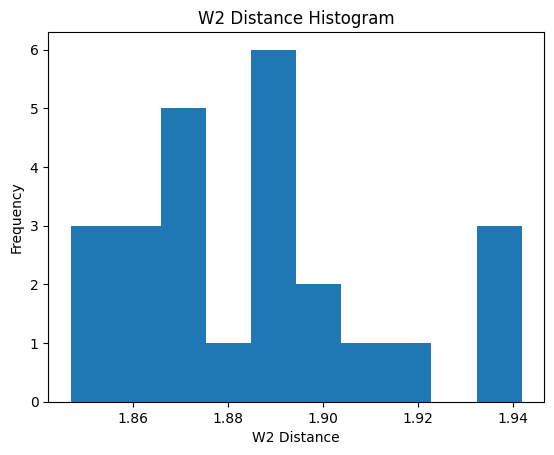

W2 Distance Mean:  1.8858461901403687
W2 Distance Std:  0.025865219544364108


In [8]:
plt.figure()
plt.hist(w2s,bins=10)
plt.xlabel("W2 Distance")
plt.ylabel("Frequency")
plt.title("W2 Distance Histogram")
plt.show()

print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))

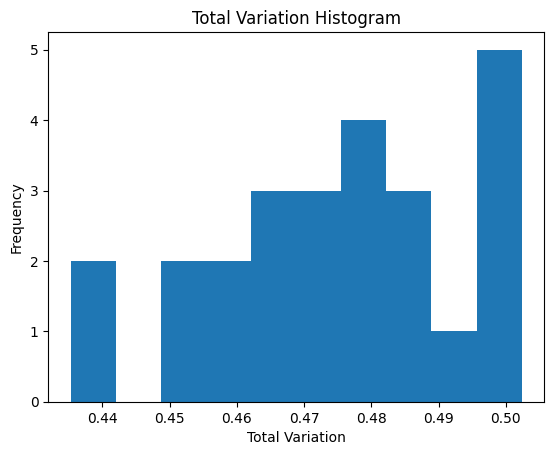

Total Variation Mean:  0.47497246
Total Variation Std:  0.018458424


In [9]:
plt.figure()
plt.hist(tvs,bins=10)
plt.xlabel("Total Variation")
plt.ylabel("Frequency")
plt.title("Total Variation Histogram")
plt.show()

print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))

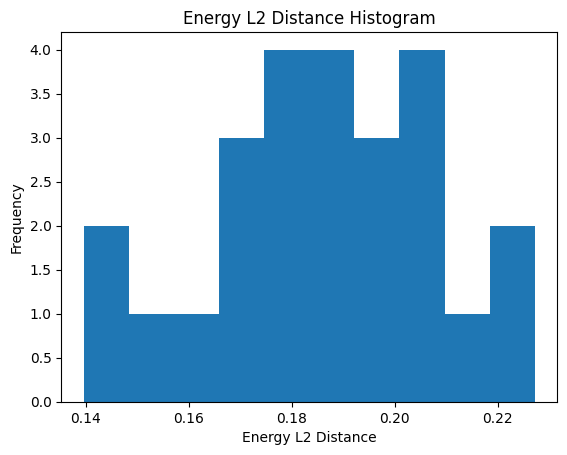

Energy L2 Distance Mean:  0.18688618585815114
Energy L2 Distance Std:  0.02264243943238474


In [10]:
plt.figure()
plt.hist(energy_l2s,bins=10)
plt.xlabel("Energy L2 Distance")
plt.ylabel("Frequency")
plt.title("Energy L2 Distance Histogram")
plt.show()

print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))

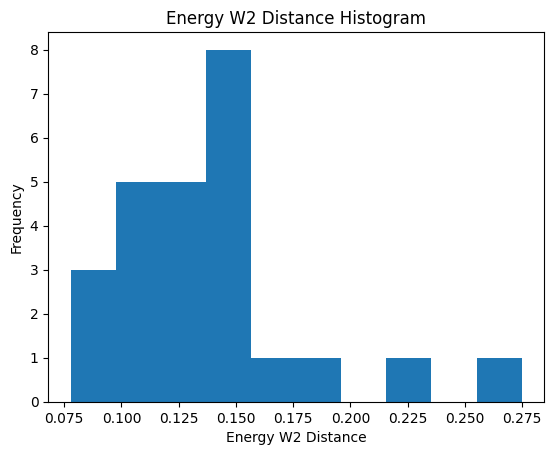

Energy W2 Distance Mean:  0.14048943
Energy W2 Distance Std:  0.041066322


In [11]:
plt.figure()
plt.hist(energy_w2s,bins=10)
plt.xlabel("Energy W2 Distance")
plt.ylabel("Frequency")
plt.title("Energy W2 Distance Histogram")
plt.show()

print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))

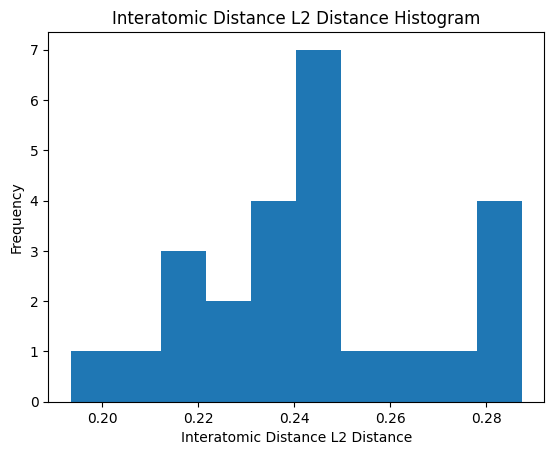

Interatomic Distance L2 Distance Mean:  0.24375059380158548
Interatomic Distance L2 Distance Std:  0.02429476194023624


In [12]:
plt.figure()
plt.hist(interatomic_l2s,bins=10)
plt.xlabel("Interatomic Distance L2 Distance")
plt.ylabel("Frequency")
plt.title("Interatomic Distance L2 Distance Histogram")
plt.show()

print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))

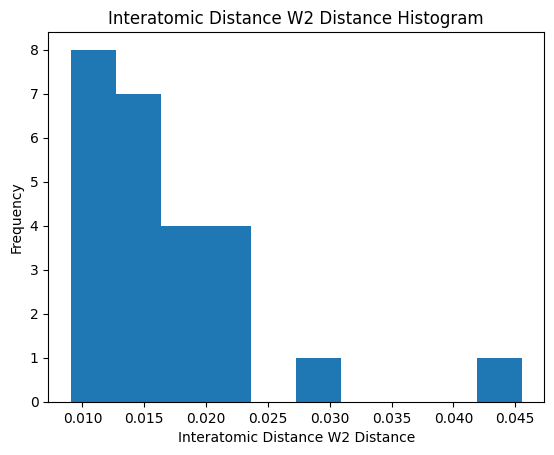

Interatomic Distance W2 Distance Mean:  0.01703183
Interatomic Distance W2 Distance Std:  0.0074056555


In [13]:
plt.figure()
plt.hist(interatomic_w2s,bins=10)
plt.xlabel("Interatomic Distance W2 Distance")
plt.ylabel("Frequency")
plt.title("Interatomic Distance W2 Distance Histogram")
plt.show()

print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

long simulation endpoint vs current reference

In [14]:
simulation_dataset=np.load("../dw4_long.npy")
torch_simulation_dataset=torch.tensor(simulation_dataset)
test_set=np.load("../data/test_split_DW4.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in tqdm.tqdm(range(25)):
    current_samples_idx=torch.multinomial(torch.ones(torch_simulation_dataset.shape[0]),torch_test_set.shape[0], replacement=False)
    current_samples=torch_simulation_dataset[current_samples_idx]
    metrics=compute_metrics(energy,current_samples,torch.tensor(test_set))
    w2s.append(metrics["W2"])
    tvs.append(metrics["Total Variation"])
    energy_l2s.append(metrics["Energy L2 Distance"])
    energy_w2s.append(metrics["Energy W2 Distance"])
    interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
    interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

100%|██████████| 25/25 [00:10<00:00,  2.46it/s]

W2 Distance Mean:  2.067093275716388
W2 Distance Std:  0.027832459749269425
Total Variation Mean:  0.50432795
Total Variation Std:  0.015914401
Energy L2 Distance Mean:  0.1538507738978001
Energy L2 Distance Std:  0.01803340274022788
Energy W2 Distance Mean:  0.12542704
Energy W2 Distance Std:  0.045298357
Interatomic Distance L2 Distance Mean:  0.27616375589778563
Interatomic Distance L2 Distance Std:  0.03313286520331193
Interatomic Distance W2 Distance Mean:  0.070336305
Interatomic Distance W2 Distance Std:  0.014620164


short simulation endpoints vs current reference

In [15]:
test_set=np.load("../data/test_split_DW4.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../dw4_endpoint{}.npy'.format(i)
    endpoint_samples=np.load(endpoint)
    torch_endpoint_samples=torch.tensor(endpoint_samples)
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))
        

W2 Distance Mean:  2.0711637854232965
W2 Distance Std:  0.02837120454006193
Total Variation Mean:  0.5106488
Total Variation Std:  0.015471255
Energy L2 Distance Mean:  0.15648569623977193
Energy L2 Distance Std:  0.021340302051006926
Energy W2 Distance Mean:  0.14019804
Energy W2 Distance Std:  0.047451332
Interatomic Distance L2 Distance Mean:  0.2830413049821637
Interatomic Distance L2 Distance Std:  0.02488306413718922
Interatomic Distance W2 Distance Mean:  0.06854107
Interatomic Distance W2 Distance Std:  0.015435605


short simulation endpoints vs new reference

In [16]:
test_set=np.load("../test_dw4_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../dw4_endpoint{}.npy'.format(i)
    endpoint_samples=np.load(endpoint)
    torch_endpoint_samples=torch.tensor(endpoint_samples)
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))
        

W2 Distance Mean:  1.8773194202007943
W2 Distance Std:  0.023823933228416954
Total Variation Mean:  0.48299882
Total Variation Std:  0.02052756
Energy L2 Distance Mean:  0.1962834638128857
Energy L2 Distance Std:  0.022442364273506057
Energy W2 Distance Mean:  0.116485804
Energy W2 Distance Std:  0.02499809
Interatomic Distance L2 Distance Mean:  0.2539026572452181
Interatomic Distance L2 Distance Std:  0.03208095111587082
Interatomic Distance W2 Distance Mean:  0.01912293
Interatomic Distance W2 Distance Std:  0.007653273


IDEM vs current reference

In [17]:
test_set=np.load("../data/test_split_DW4.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../IDEM_samples/DW4_{}_samples_100000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2717477/4159805577.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  2.052909992369595
W2 Distance Std:  0.024666668419809724
Total Variation Mean:  0.51511186
Total Variation Std:  0.014113103
Energy L2 Distance Mean:  0.18472534158445714
Energy L2 Distance Std:  0.03508091551837824
Energy W2 Distance Mean:  0.42566726
Energy W2 Distance Std:  0.15639399
Interatomic Distance L2 Distance Mean:  0.34750001955247034
Interatomic Distance L2 Distance Std:  0.0197195580334429
Interatomic Distance W2 Distance Mean:  0.13128486
Interatomic Distance W2 Distance Std:  0.015831433


IDEM vs new reference

In [18]:
test_set=np.load("../test_dw4_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../IDEM_samples/DW4_{}_samples_100000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2717477/3833019629.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  1.9064803431441186
W2 Distance Std:  0.026435558053332378
Total Variation Mean:  0.48211202
Total Variation Std:  0.017820854
Energy L2 Distance Mean:  0.24261916730160793
Energy L2 Distance Std:  0.03366899239795209
Energy W2 Distance Mean:  0.6194037
Energy W2 Distance Std:  0.164192
Interatomic Distance L2 Distance Mean:  0.5035517532408469
Interatomic Distance L2 Distance Std:  0.023433466407877652
Interatomic Distance W2 Distance Mean:  0.20340306
Interatomic Distance W2 Distance Std:  0.012756509


IEFM vs current reference

In [19]:
test_set=np.load("../data/test_split_DW4.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../IEFM_samples/DW4_{}_samples_100000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2717477/860162307.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  2.1208629355621444
W2 Distance Std:  0.025808928407350946
Total Variation Mean:  0.5100814
Total Variation Std:  0.018648032
Energy L2 Distance Mean:  0.3189899239385891
Energy L2 Distance Std:  0.023424411542094847
Energy W2 Distance Mean:  3.7306795
Energy W2 Distance Std:  0.83552665
Interatomic Distance L2 Distance Mean:  0.6710020691615809
Interatomic Distance L2 Distance Std:  0.03183136679944541
Interatomic Distance W2 Distance Mean:  0.21012397
Interatomic Distance W2 Distance Std:  0.018068653


IDEM vs new reference

In [20]:
test_set=np.load("../test_dw4_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../IEFM_samples/DW4_{}_samples_100000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2717477/1635562200.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  1.9267270841945572
W2 Distance Std:  0.02216129443776946
Total Variation Mean:  0.48271665
Total Variation Std:  0.014103909
Energy L2 Distance Mean:  0.3494429498350321
Energy L2 Distance Std:  0.023206301361466806
Energy W2 Distance Mean:  3.831085
Energy W2 Distance Std:  0.6671032
Interatomic Distance L2 Distance Mean:  0.6347263001250346
Interatomic Distance L2 Distance Std:  0.03482661882398411
Interatomic Distance W2 Distance Mean:  0.14213654
Interatomic Distance W2 Distance Std:  0.010803978


Interatomic distance histogram

In [21]:
test_set=np.load("../data/test_split_DW4.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
dist_current_reference = energy.interatomic_dist(torch_test_set).detach().cpu()
test_set=np.load("../test_dw4_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
dist_new_reference = energy.interatomic_dist(torch_test_set).detach().cpu()
endpoint='../dw4_endpoint1.npy'
endpoint_samples=np.load(endpoint)
torch_endpoint_samples=torch.tensor(endpoint_samples)
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
dist_mcmc_reference = energy.interatomic_dist(current_samples).detach().cpu()
endpoint='../IDEM_samples/DW4_1_samples_100000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
dist_idem_reference = energy.interatomic_dist(current_samples).detach().cpu()
endpoint='../IEFM_samples/DW4_1_samples_100000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
dist_iefm_reference = energy.interatomic_dist(current_samples).detach().cpu()

/tmp/ipykernel_2717477/3731439372.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
/tmp/ipyk

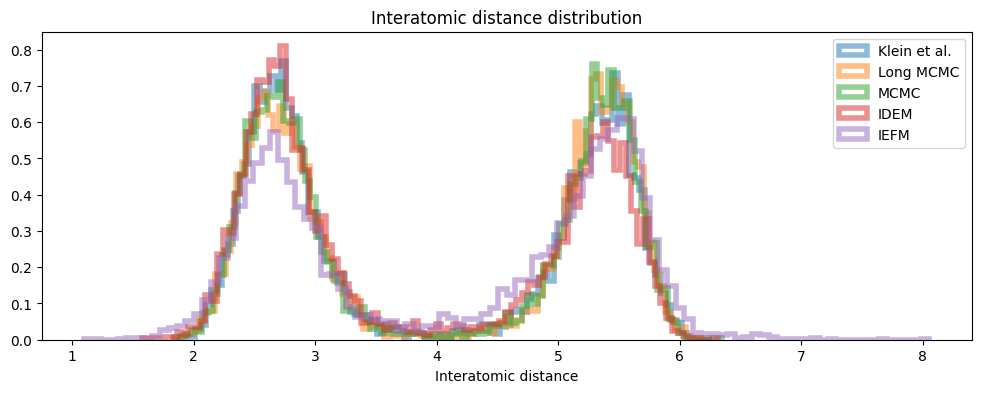

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(
        dist_current_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_new_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_mcmc_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_idem_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_iefm_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.set_xlabel("Interatomic distance")
ax.legend(["Klein et al.", "Long MCMC", "MCMC", "IDEM","IEFM"])
ax.set_title("Interatomic distance distribution")
figure=fig_to_image(fig)
figure.save("dw4_interatomic_distance_distribution.png")

Energy histogram distribution

In [23]:
test_set=np.load("../data/test_split_DW4.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
energy_current_reference = -energy(torch_test_set).detach().cpu()
test_set=np.load("../test_dw4_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
energy_new_reference = -energy(torch_test_set).detach().cpu()
endpoint='../dw4_endpoint1.npy'
endpoint_samples=np.load(endpoint)
torch_endpoint_samples=torch.tensor(endpoint_samples)
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
energy_mcmc_reference = -energy(current_samples).detach().cpu()
endpoint='../IDEM_samples/DW4_1_samples_100000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
energy_idem_reference = -energy(current_samples).detach().cpu()
endpoint='../IEFM_samples/DW4_1_samples_100000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
energy_iefm_reference = -energy(current_samples).detach().cpu()

/tmp/ipykernel_2717477/3089456221.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
/tmp/ipyk

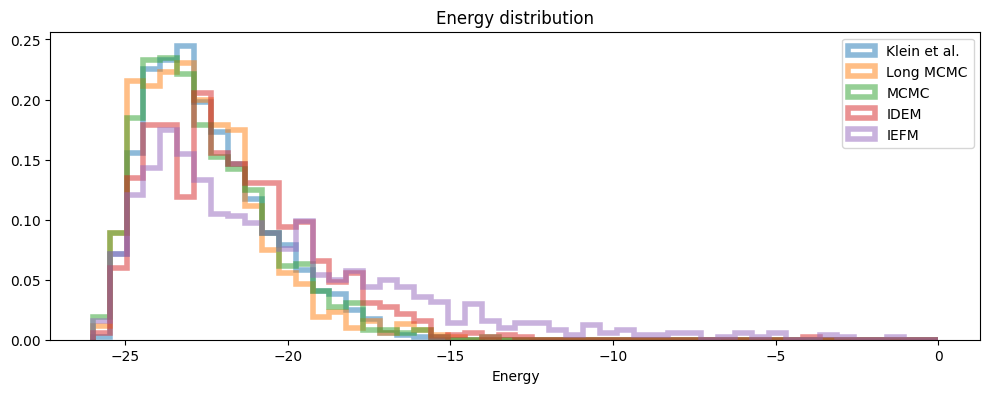

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
min_energy = -26
max_energy = 0
ax.hist(
        energy_current_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_new_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_mcmc_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_idem_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_iefm_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.set_xlabel("Energy")
ax.legend(["Klein et al.", "Long MCMC", "MCMC", "IDEM","IEFM"])
ax.set_title("Energy distribution")
figure=fig_to_image(fig)
figure.save("dw4_energy_distribution.png")